In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt

from deep_hedging import (
    Underlyings,
    Ticker,
    ConstantRateCurve,
    EuropeanCall,
)
from deep_hedging.hedger import HedgeSimulator
from deep_hedging.monte_carlo import GBMSimulator

RANDOM_SEED = 12

In [3]:
N_PATHS = 20_000
N_STOCKS = 1
TILL_MATURITY = 3.0
N_DAYS = 365 * TILL_MATURITY
RF_RATE = 0.03
VOL = 0.2

In [4]:
np.random.seed(RANDOM_SEED)

start = dt.datetime(2019, 1, 1)
end = start + dt.timedelta(days=N_DAYS)

underlyings = Underlyings(
    tickers=[Ticker(f"Stock {i + 1}", f"{i + 1}") for i in range(N_STOCKS)],
    start=start,
    end=end,
    dividends=np.array([0.0] * N_STOCKS),
    means=np.array([RF_RATE] * N_STOCKS),
    var_covar=np.array([VOL**2] * N_STOCKS),
)
underlyings.data

In [5]:
curve = ConstantRateCurve(constant_rate=RF_RATE)

In [6]:
european_call = EuropeanCall(
    underlyings=underlyings,
    yield_curve=curve,
    strike_level=1.0,
    start_date=start,
    end_date=end,
)

In [7]:
pricer = GBMSimulator(payoff_function=european_call.payoff, random_seed=RANDOM_SEED)
hedger = HedgeSimulator(european_call, look_ahead=True)

In [8]:
pnls = []
for vol_coef in np.arange(0.1, 10.0, 0.1):
    paths = pricer.get_paths(
        spot=[1.0],
        time_till_maturity=TILL_MATURITY,
        risk_free_rate_fn=curve.get_instant_fwd_rate,
        dividends_fn=lambda t: 0.0,
        var_covar_fn=lambda t: np.array([(vol_coef * VOL) ** 2] * len(t)),
        n_paths=N_PATHS,
    ).squeeze(2)
    pnl_hedge, pnl_opt = hedger.simulate(
        bids=paths,
        asks=paths,
        rates_lend=curve(european_call.days_till_maturity) / 365,
        rates_borrow=curve(european_call.days_till_maturity) / 365,
    )
    pnls.append([vol_coef * VOL * 100, pnl_hedge.mean().item(), pnl_opt.mean().item()])
pnls = np.array(pnls)

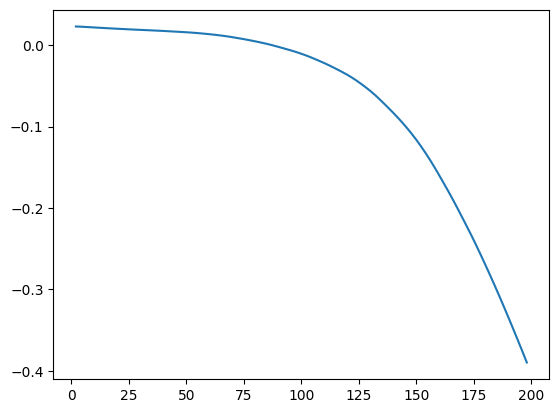

In [9]:
plt.plot(pnls[:, 0], pnls[:, 1])
plt.show()

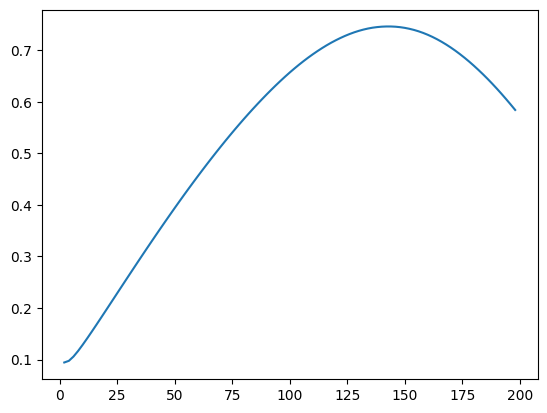

In [10]:
plt.plot(pnls[:, 0], pnls[:, 2])
plt.show()

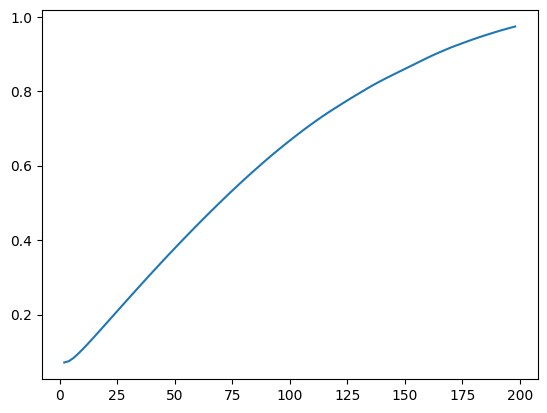

In [11]:
plt.plot(pnls[:, 0], pnls[:, 2] - pnls[:, 1])
plt.show()

In [12]:
pnls[:, 2]

array([0.09436137, 0.09754178, 0.10582266, 0.11661859, 0.1286728 ,
       0.141363  , 0.15442457, 0.16769763, 0.1811269 , 0.19465461,
       0.20823097, 0.22181513, 0.23540302, 0.24896664, 0.26251009,
       0.27601096, 0.28945738, 0.30282746, 0.31612635, 0.32932941,
       0.34243648, 0.35544856, 0.36835464, 0.38115432, 0.39383924,
       0.40640482, 0.41883791, 0.43112443, 0.44325673, 0.45525027,
       0.4671018 , 0.47879115, 0.4903267 , 0.50169249, 0.51288806,
       0.52391361, 0.53475895, 0.5454081 , 0.55586977, 0.56613012,
       0.57617989, 0.58601821, 0.59564217, 0.60505633, 0.61426456,
       0.62323122, 0.63196281, 0.64043181, 0.64866948, 0.65662202,
       0.66427357, 0.67162989, 0.67868627, 0.68543787, 0.6918619 ,
       0.69797841, 0.70378749, 0.70926563, 0.71438371, 0.71911995,
       0.72351368, 0.72756304, 0.7312278 , 0.73450444, 0.7373803 ,
       0.73984443, 0.74191211, 0.74354174, 0.74473065, 0.74552439,
       0.74591002, 0.74589351, 0.74545267, 0.7445592 , 0.74322

In [13]:
pnls[:, 2] - pnls[:, 1]

array([0.07144274, 0.07487934, 0.08345731, 0.09457853, 0.10696562,
       0.11997903, 0.13336243, 0.14695764, 0.16069792, 0.17451872,
       0.18837909, 0.20224768, 0.21611895, 0.22996028, 0.24376603,
       0.25751149, 0.27120743, 0.28484189, 0.29841269, 0.31190178,
       0.3253202 , 0.33865481, 0.35187596, 0.36500123, 0.37802302,
       0.39096254, 0.40382327, 0.41659634, 0.42925145, 0.44179474,
       0.45425381, 0.46660503, 0.47885717, 0.49101508, 0.50310599,
       0.51508243, 0.5269025 , 0.53858467, 0.55010853, 0.56147845,
       0.5727172 , 0.58381609, 0.59476663, 0.6056363 , 0.61638003,
       0.62691359, 0.63725561, 0.64736652, 0.65735519, 0.66720502,
       0.67687966, 0.68644048, 0.69588706, 0.70502973, 0.71394486,
       0.7227037 , 0.73133604, 0.73964595, 0.74772679, 0.75558151,
       0.7633713 , 0.77113409, 0.77881545, 0.78632543, 0.79368445,
       0.80100786, 0.80836282, 0.81548593, 0.82229356, 0.82878552,
       0.83514811, 0.84134141, 0.84749092, 0.85353166, 0.85955

### Misassessed vol.

Without price.

In [14]:
vols_iter = np.concatenate((np.arange(0.2, 0.5, 0.1), np.arange(0.5, 4.0, 0.5)), axis=0)
vols_iter

array([0.2, 0.3, 0.4, 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5])

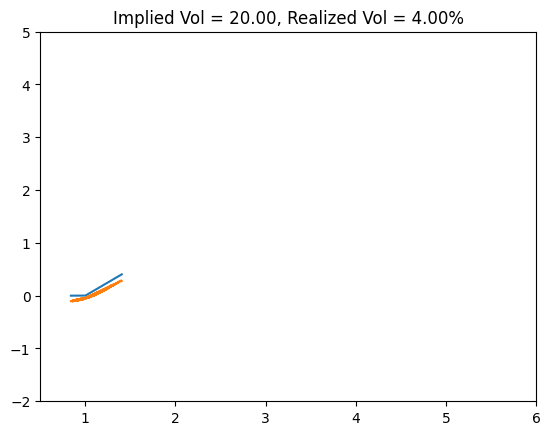

0.07487934495261708


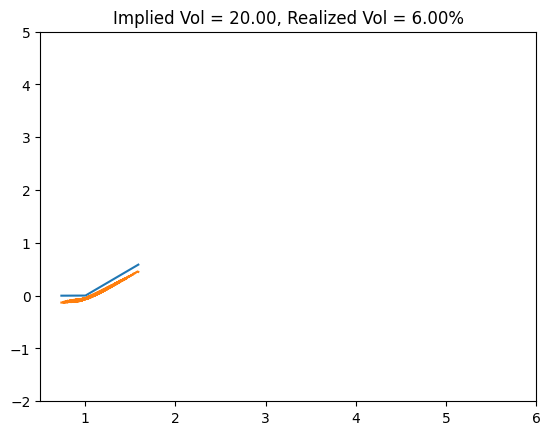

0.08345730578601453


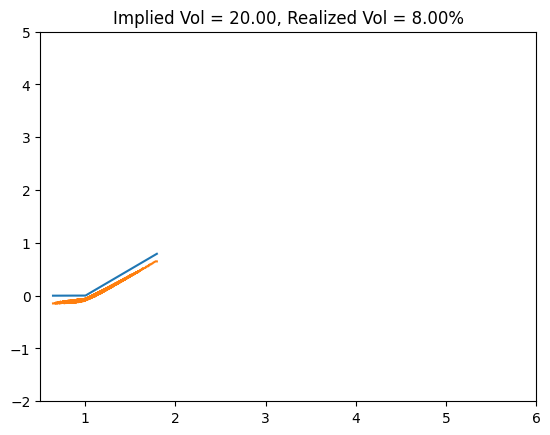

0.0945785322800499


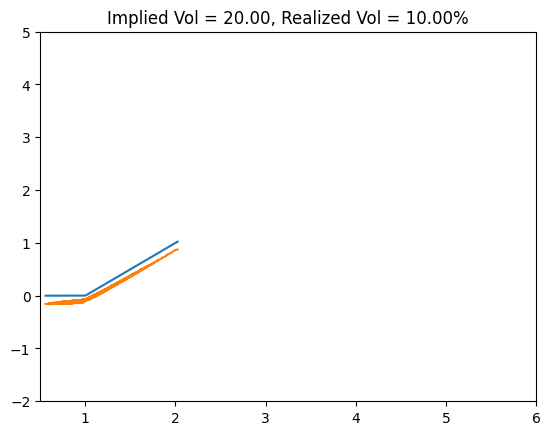

0.10696562060379626


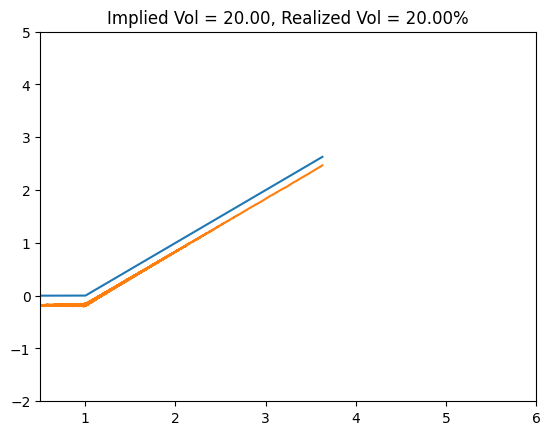

0.1745187189296203


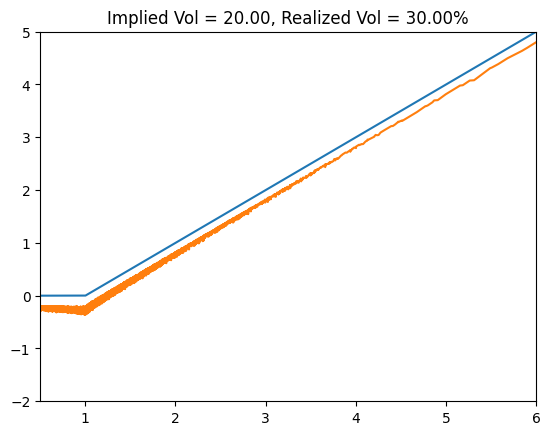

0.243766026802827


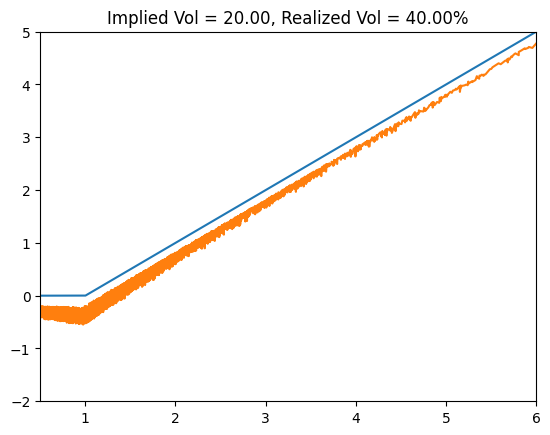

0.31190177939860314


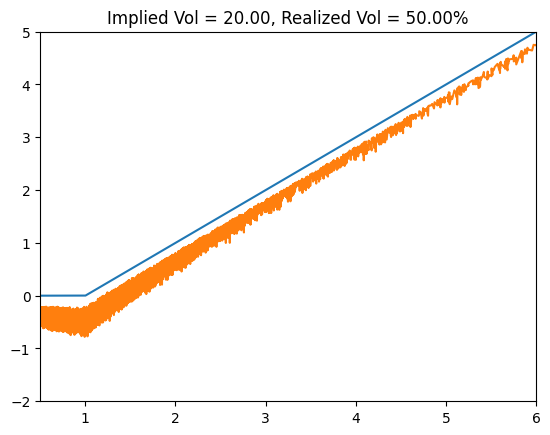

0.37802301772785496


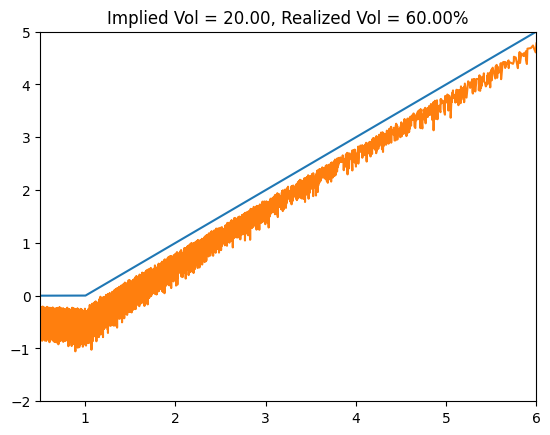

0.44179474382824735


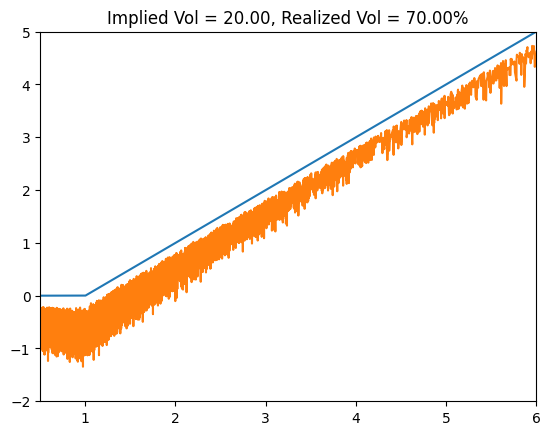

0.5031059918371165


In [15]:
pnls = []
for vol_coef in vols_iter:
    paths = pricer.get_paths(
        spot=[1.0],
        time_till_maturity=TILL_MATURITY,
        risk_free_rate_fn=curve.get_instant_fwd_rate,
        dividends_fn=lambda t: 0.0,
        var_covar_fn=lambda t: np.array([(vol_coef * VOL) ** 2] * len(t)),
        n_paths=N_PATHS,
    ).squeeze(2)
    pnl_hedge, pnl_opt = hedger.simulate(
        bids=paths,
        asks=paths,
        rates_lend=curve(european_call.days_till_maturity) / 365,
        rates_borrow=curve(european_call.days_till_maturity) / 365,
    )
    plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
    plt.plot(
        np.sort(paths[:, -1]),
        pnl_hedge[np.argsort(paths[:, -1])],
    )
    plt.xlim(0.5, 6)
    plt.ylim(-2, 5)
    plt.title(
        f"Implied Vol = {VOL * 100:.2f}, Realized Vol = {vol_coef * VOL * 100:.2f}%"
    )
    plt.show()
    print((pnl_opt - pnl_hedge).mean())

With price.

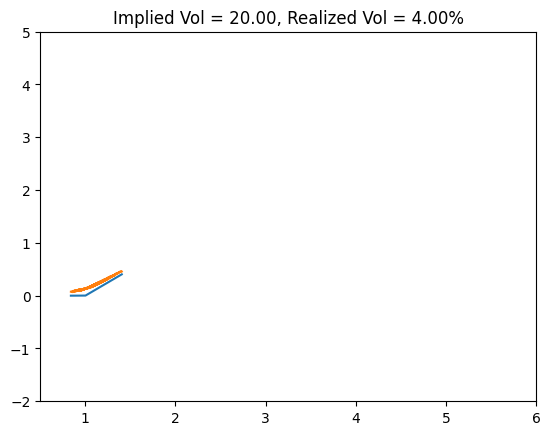

0.07487934495261708


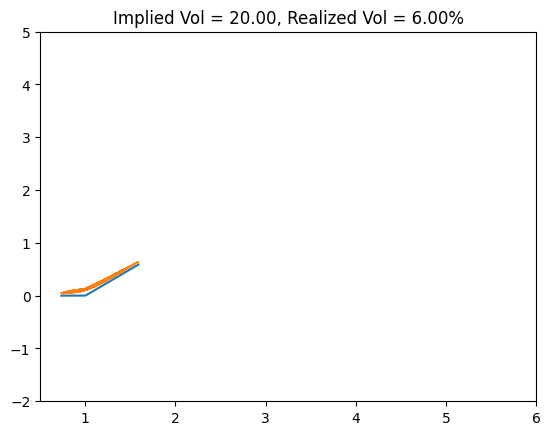

0.08345730578601453


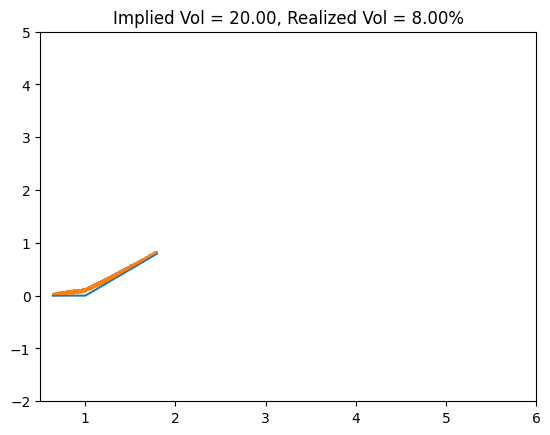

0.0945785322800499


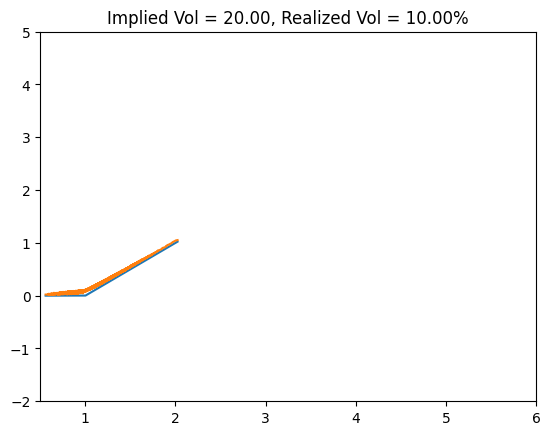

0.10696562060379626


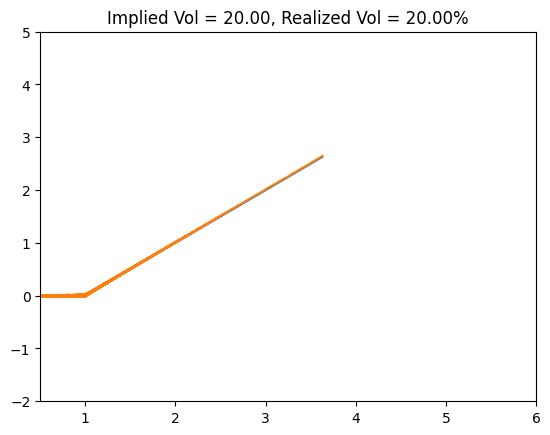

0.1745187189296203


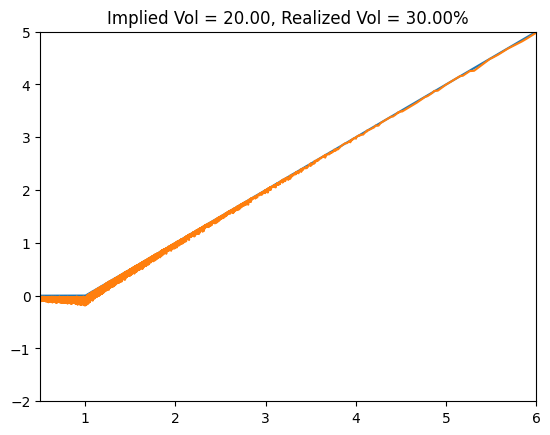

0.243766026802827


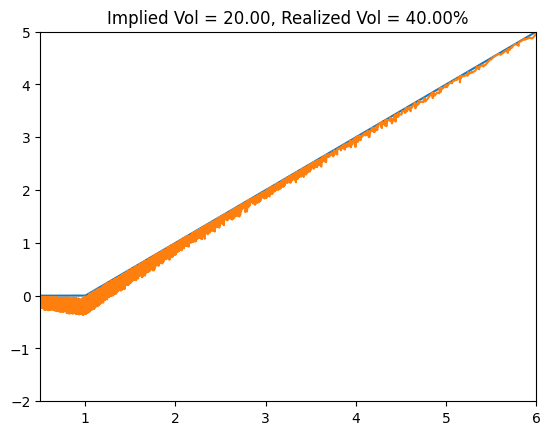

0.31190177939860314


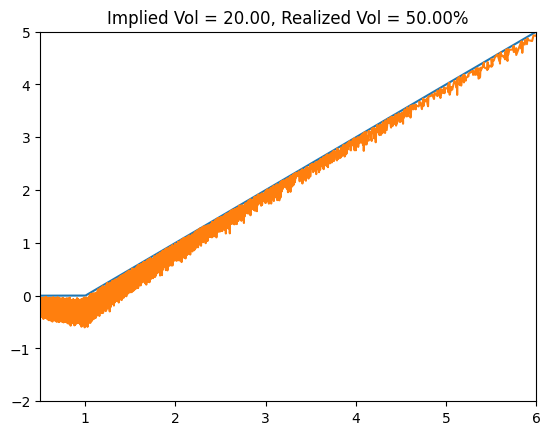

0.37802301772785496


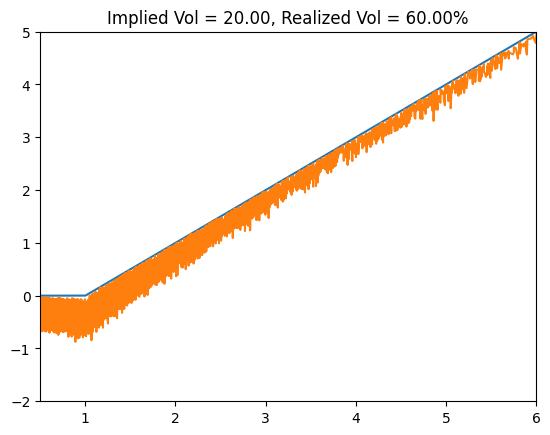

0.44179474382824735


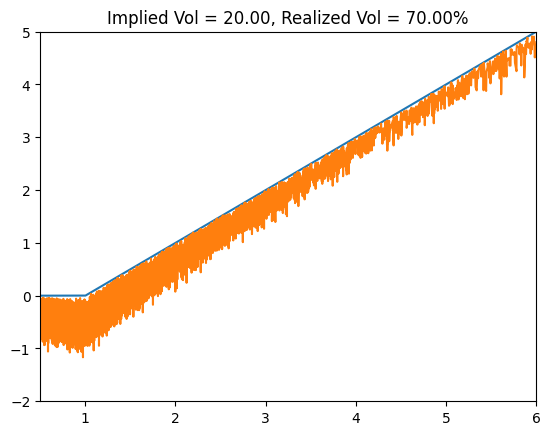

0.5031059918371165


In [16]:
pnls = []
for vol_coef in vols_iter:
    paths = pricer.get_paths(
        spot=[1.0],
        time_till_maturity=TILL_MATURITY,
        risk_free_rate_fn=curve.get_instant_fwd_rate,
        dividends_fn=lambda t: 0.0,
        var_covar_fn=lambda t: np.array([(vol_coef * VOL) ** 2] * len(t)),
        n_paths=N_PATHS,
    ).squeeze(2)
    pnl_hedge, pnl_opt = hedger.simulate(
        bids=paths,
        asks=paths,
        rates_lend=curve(european_call.days_till_maturity) / 365,
        rates_borrow=curve(european_call.days_till_maturity) / 365,
    )
    plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
    plt.plot(
        np.sort(paths[:, -1]),
        pnl_hedge[np.argsort(paths[:, -1])] + european_call.price().T.squeeze(1),
    )
    plt.xlim(0.5, 6)
    plt.ylim(-2, 5)
    plt.title(
        f"Implied Vol = {VOL * 100:.2f}, Realized Vol = {vol_coef * VOL * 100:.2f}%"
    )
    plt.show()
    print((pnl_opt - pnl_hedge).mean())

### Correct Vol.

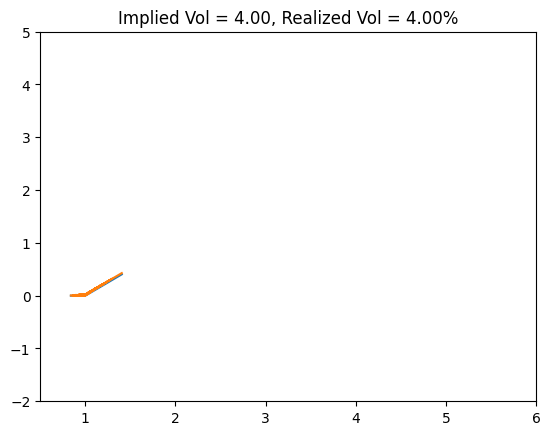

0.06835746342355495


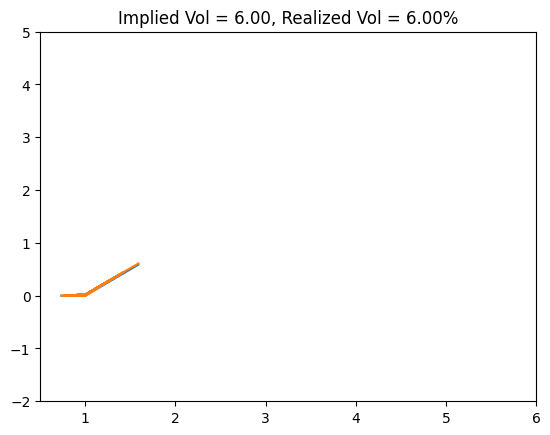

0.0794970623269423


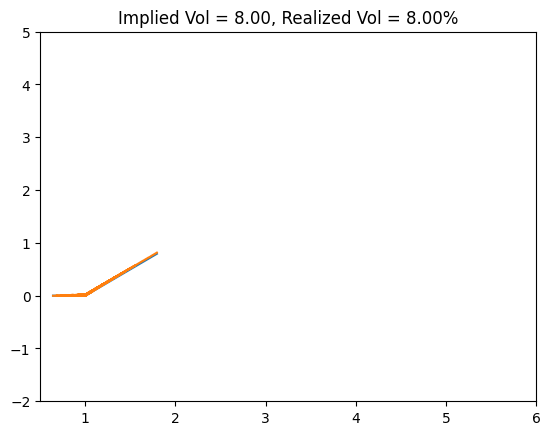

0.09222929263916267


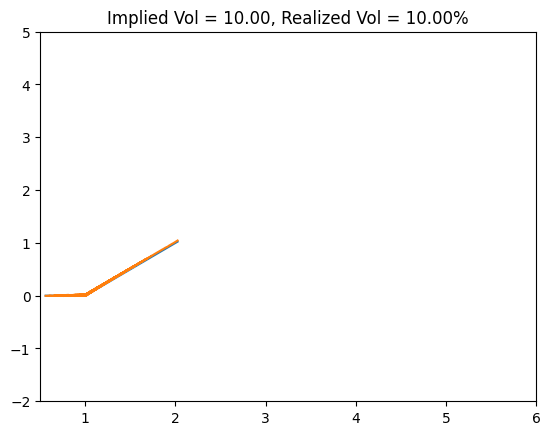

0.10557084134553128


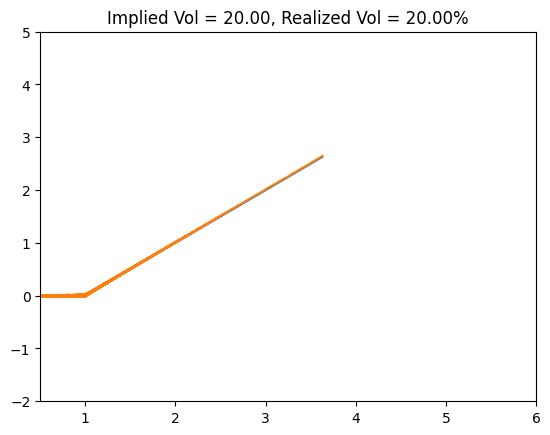

0.1745187189296203


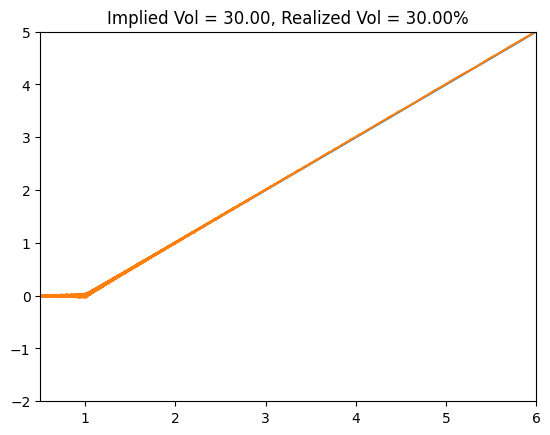

0.24357313696959226


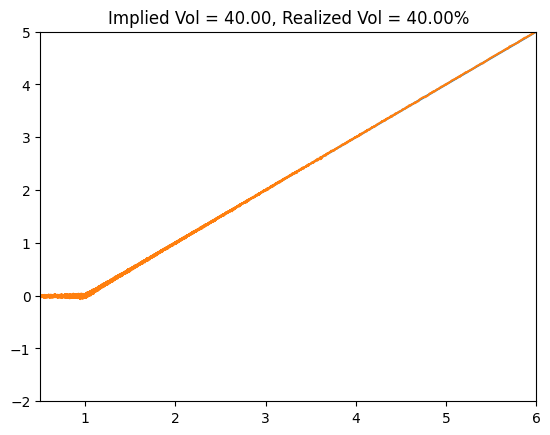

0.31135761298979997


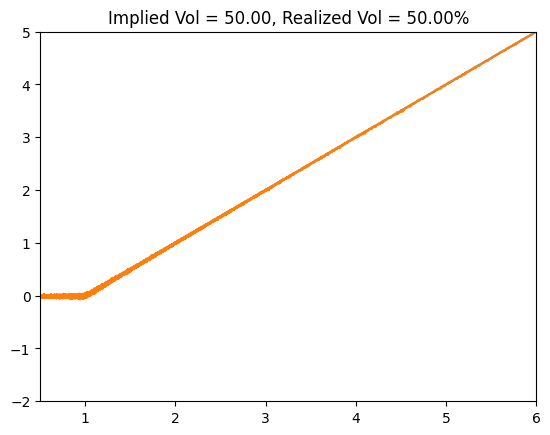

0.37722697268978855


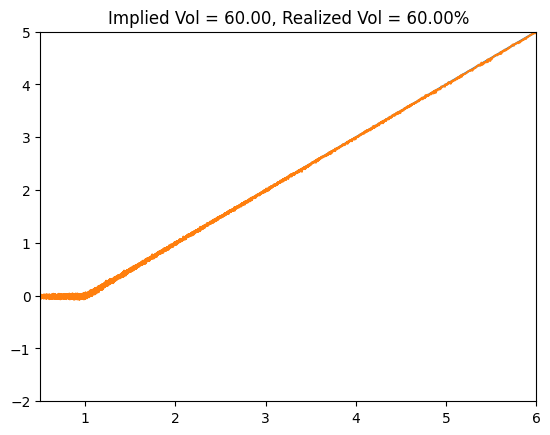

0.44069520538691975


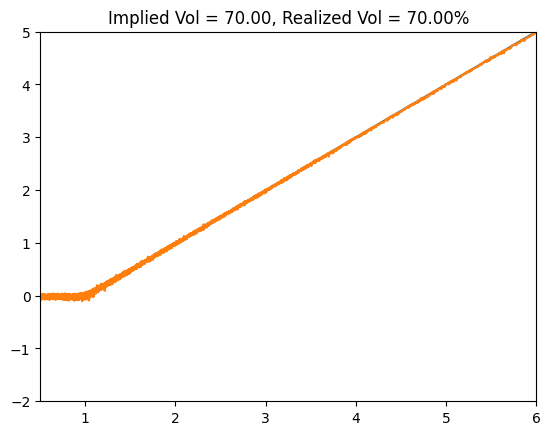

0.5013450694929573


In [17]:
pnls = []
for vol_coef in vols_iter:
    underlyings = Underlyings(
        tickers=[Ticker(f"Stock {i + 1}", f"{i + 1}") for i in range(N_STOCKS)],
        start=start,
        end=end,
        dividends=np.array([0.0] * N_STOCKS),
        means=np.array([RF_RATE] * N_STOCKS),
        var_covar=np.array([(vol_coef * VOL) ** 2] * N_STOCKS),
    )

    european_call = EuropeanCall(
        underlyings=underlyings,
        yield_curve=curve,
        strike_level=1.0,
        start_date=start,
        end_date=end,
    )

    pricer = GBMSimulator(payoff_function=european_call.payoff, random_seed=RANDOM_SEED)
    hedger = HedgeSimulator(european_call, look_ahead=True)

    paths = pricer.get_paths(
        spot=[1.0],
        time_till_maturity=TILL_MATURITY,
        risk_free_rate_fn=curve.get_instant_fwd_rate,
        dividends_fn=lambda t: 0.0,
        var_covar_fn=lambda t: np.array([(vol_coef * VOL) ** 2] * len(t)),
        n_paths=N_PATHS,
    ).squeeze(2)

    pnl_hedge, pnl_opt = hedger.simulate(
        bids=paths,
        asks=paths,
        rates_lend=curve(european_call.days_till_maturity) / 365,
        rates_borrow=curve(european_call.days_till_maturity) / 365,
    )

    plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
    plt.plot(
        np.sort(paths[:, -1]),
        pnl_hedge[np.argsort(paths[:, -1])] + european_call.price().T.squeeze(1),
    )
    plt.xlim(0.5, 6)
    plt.ylim(-2, 5)
    plt.title(
        f"Implied Vol = {vol_coef * VOL * 100:.2f}, Realized Vol = {vol_coef * VOL * 100:.2f}%"
    )
    plt.show()
    print((pnl_opt - pnl_hedge).mean())

### На одном ли и том же уровне уголок дельта-хеджа?

In [18]:
underlyings = Underlyings(
    tickers=[Ticker(f"Stock {i + 1}", f"{i + 1}") for i in range(N_STOCKS)],
    start=start,
    end=end,
    dividends=np.array([0.0] * N_STOCKS),
    means=np.array([RF_RATE] * N_STOCKS),
    var_covar=np.array([VOL**2] * N_STOCKS),
)

european_call = EuropeanCall(
    underlyings=underlyings,
    yield_curve=curve,
    strike_level=1.0,
    start_date=start,
    end_date=end,
)

Miss.

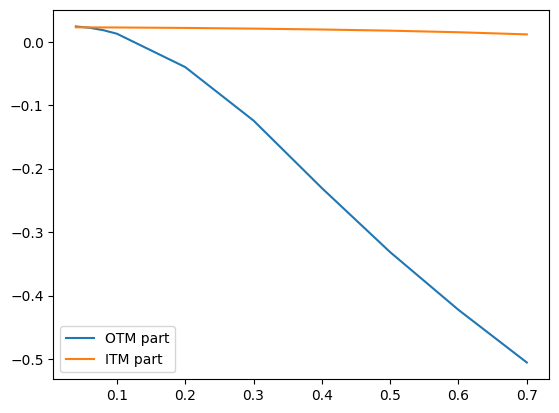

In [19]:
moments = []
for vol_coef in vols_iter:
    paths = pricer.get_paths(
        spot=[1.0],
        time_till_maturity=TILL_MATURITY,
        risk_free_rate_fn=curve.get_instant_fwd_rate,
        dividends_fn=lambda t: 0.0,
        var_covar_fn=lambda t: np.array([(vol_coef * VOL) ** 2] * len(t)),
        n_paths=N_PATHS,
    ).squeeze(2)
    pnl_hedge, _ = hedger.simulate(
        bids=paths,
        asks=paths,
        rates_lend=curve(european_call.days_till_maturity) / 365,
        rates_borrow=curve(european_call.days_till_maturity) / 365,
    )
    moments.append(
        [
            vol_coef * VOL,
            pnl_hedge[np.argsort(paths[:, -1]) <= 1].mean(),
            pnl_hedge[np.argsort(paths[:, -1]) > 1].mean(),
        ]
    )

moments = np.array(moments)
plt.plot(moments[:, 0], moments[:, 1])
plt.plot(moments[:, 0], moments[:, 2])
plt.legend(["OTM part", "ITM part"])
plt.show()

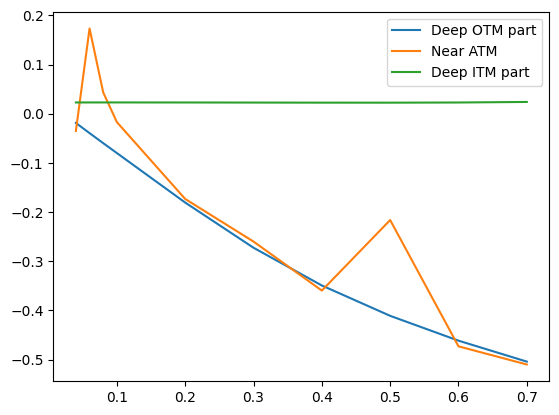

In [20]:
STEP_FROM_ATM = 0.2

moments = []
for vol_coef in vols_iter:
    paths = pricer.get_paths(
        spot=[1.0],
        time_till_maturity=TILL_MATURITY,
        risk_free_rate_fn=curve.get_instant_fwd_rate,
        dividends_fn=lambda t: 0.0,
        var_covar_fn=lambda t: np.array([(vol_coef * VOL) ** 2] * len(t)),
        n_paths=50_000,
    ).squeeze(2)
    pnl_hedge, _ = hedger.simulate(
        bids=paths,
        asks=paths,
        rates_lend=curve(european_call.days_till_maturity) / 365,
        rates_borrow=curve(european_call.days_till_maturity) / 365,
    )
    moments.append(
        [
            vol_coef * VOL,
            pnl_hedge[np.argsort(paths[:, -1]) <= 1 - STEP_FROM_ATM].mean(),
            pnl_hedge[
                np.argsort(1 - STEP_FROM_ATM < paths[:, -1]) <= 1 + STEP_FROM_ATM
            ].mean(),
            pnl_hedge[np.argsort(paths[:, -1]) > 1 + STEP_FROM_ATM].mean(),
        ]
    )

moments = np.array(moments)
plt.plot(moments[:, 0], moments[:, 1])
plt.plot(moments[:, 0], moments[:, 2])
plt.plot(moments[:, 0], moments[:, 3])
plt.legend(["Deep OTM part", "Near ATM", "Deep ITM part"])
plt.show()

In [21]:
print(moments[:, 3].mean())

0.022915950085654117


In [22]:
for vol, pnl_itm in zip(moments[:, 0], moments[:, 3]):
    print(vol, pnl_itm, vol * np.sqrt(2) / np.sqrt(np.pi))

0.04000000000000001 0.0229087096764564 0.03191538243211463
0.06000000000000001 0.022941121865543947 0.047873073648171935
0.08000000000000002 0.022960691709449123 0.06383076486422926
0.1 0.022968645665056624 0.07978845608028656
0.2 0.02287899231455881 0.15957691216057313
0.30000000000000004 0.022699323198388265 0.2393653682408597
0.4 0.022527685074171674 0.31915382432114625
0.5 0.02248508451622235 0.39894228040143276
0.6000000000000001 0.022831171864781973 0.4787307364817194
0.7000000000000001 0.023958074971911998 0.5585191925620059


In [30]:
european_call.delta() * RF_RATE

array([[0.02312975]])

Correct.

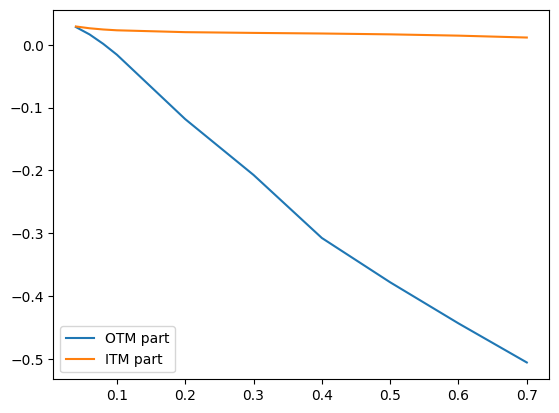

In [23]:
moments = []
for vol_coef in vols_iter:
    underlyings = Underlyings(
        tickers=[Ticker(f"Stock {i + 1}", f"{i + 1}") for i in range(N_STOCKS)],
        start=start,
        end=end,
        dividends=np.array([0.0] * N_STOCKS),
        means=np.array([RF_RATE] * N_STOCKS),
        var_covar=np.array([(vol_coef * VOL) ** 2] * N_STOCKS),
    )

    european_call = EuropeanCall(
        underlyings=underlyings,
        yield_curve=curve,
        strike_level=1.0,
        start_date=start,
        end_date=end,
    )

    pricer = GBMSimulator(payoff_function=european_call.payoff, random_seed=RANDOM_SEED)
    hedger = HedgeSimulator(european_call, look_ahead=True)

    paths = pricer.get_paths(
        spot=[1.0],
        time_till_maturity=TILL_MATURITY,
        risk_free_rate_fn=curve.get_instant_fwd_rate,
        dividends_fn=lambda t: 0.0,
        var_covar_fn=lambda t: np.array([(vol_coef * VOL) ** 2] * len(t)),
        n_paths=N_PATHS,
    ).squeeze(2)
    pnl_hedge, _ = hedger.simulate(
        bids=paths,
        asks=paths,
        rates_lend=curve(european_call.days_till_maturity) / 365,
        rates_borrow=curve(european_call.days_till_maturity) / 365,
    )
    moments.append(
        [
            vol_coef * VOL,
            pnl_hedge[np.argsort(paths[:, -1]) <= 1].mean(),
            pnl_hedge[np.argsort(paths[:, -1]) > 1].mean(),
        ]
    )

moments = np.array(moments)
plt.plot(moments[:, 0], moments[:, 1])
plt.plot(moments[:, 0], moments[:, 2])
plt.legend(["OTM part", "ITM part"])
plt.show()

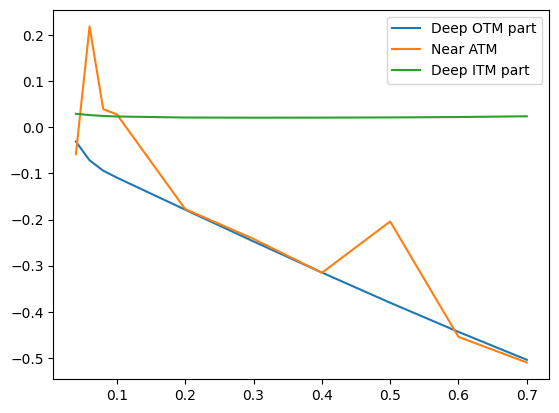

In [24]:
STEP_FROM_ATM = 0.2

moments = []
for vol_coef in vols_iter:
    underlyings = Underlyings(
        tickers=[Ticker(f"Stock {i + 1}", f"{i + 1}") for i in range(N_STOCKS)],
        start=start,
        end=end,
        dividends=np.array([0.0] * N_STOCKS),
        means=np.array([RF_RATE] * N_STOCKS),
        var_covar=np.array([(vol_coef * VOL) ** 2] * N_STOCKS),
    )

    european_call = EuropeanCall(
        underlyings=underlyings,
        yield_curve=curve,
        strike_level=1.0,
        start_date=start,
        end_date=end,
    )

    pricer = GBMSimulator(payoff_function=european_call.payoff, random_seed=RANDOM_SEED)
    hedger = HedgeSimulator(european_call, look_ahead=True)

    paths = pricer.get_paths(
        spot=[1.0],
        time_till_maturity=TILL_MATURITY,
        risk_free_rate_fn=curve.get_instant_fwd_rate,
        dividends_fn=lambda t: 0.0,
        var_covar_fn=lambda t: np.array([(vol_coef * VOL) ** 2] * len(t)),
        n_paths=50_000,
    ).squeeze(2)
    pnl_hedge, _ = hedger.simulate(
        bids=paths,
        asks=paths,
        rates_lend=curve(european_call.days_till_maturity) / 365,
        rates_borrow=curve(european_call.days_till_maturity) / 365,
    )
    moments.append(
        [
            vol_coef * VOL,
            pnl_hedge[np.argsort(paths[:, -1]) <= 1 - STEP_FROM_ATM].mean(),
            pnl_hedge[
                np.argsort(1 - STEP_FROM_ATM < paths[:, -1]) <= 1 + STEP_FROM_ATM
            ].mean(),
            pnl_hedge[np.argsort(paths[:, -1]) > 1 + STEP_FROM_ATM].mean(),
        ]
    )

moments = np.array(moments)
plt.plot(moments[:, 0], moments[:, 1])
plt.plot(moments[:, 0], moments[:, 2])
plt.plot(moments[:, 0], moments[:, 3])
plt.legend(["Deep OTM part", "Near ATM", "Deep ITM part"])
plt.show()

Можно ли заработать на воле с помощью дельта-хеджа?

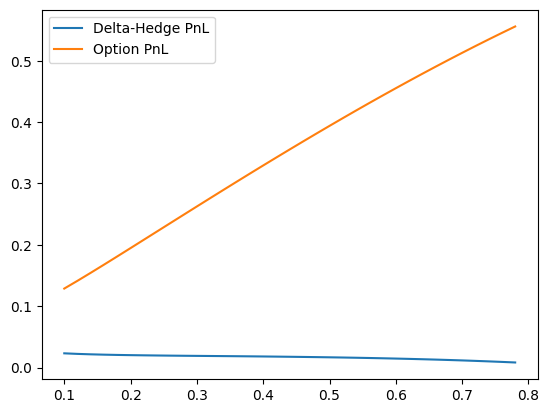

In [25]:
pnls = []
for volatility in np.arange(0.1, 0.8, 0.02):
    underlyings = Underlyings(
        tickers=[Ticker(f"Stock {i + 1}", f"{i + 1}") for i in range(N_STOCKS)],
        start=start,
        end=end,
        dividends=np.array([0.0] * N_STOCKS),
        means=np.array([RF_RATE] * N_STOCKS),
        var_covar=np.array([volatility**2] * N_STOCKS),
    )

    european_call = EuropeanCall(
        underlyings=underlyings,
        yield_curve=curve,
        strike_level=1.0,
        start_date=start,
        end_date=end,
    )

    pricer = GBMSimulator(payoff_function=european_call.payoff, random_seed=RANDOM_SEED)
    hedger = HedgeSimulator(european_call, look_ahead=True)

    paths = pricer.get_paths(
        spot=[1.0],
        time_till_maturity=TILL_MATURITY,
        risk_free_rate_fn=curve.get_instant_fwd_rate,
        dividends_fn=lambda t: 0.0,
        var_covar_fn=lambda t: np.array([volatility**2] * len(t)),
        n_paths=N_PATHS,
    ).squeeze(2)

    pnl_hedge, pnl_opt = hedger.simulate(
        bids=paths,
        asks=paths,
        rates_lend=curve(european_call.days_till_maturity) / 365,
        rates_borrow=curve(european_call.days_till_maturity) / 365,
    )

    pnls.append(
        [volatility, pnl_hedge.mean(), pnl_opt.mean(), (pnl_hedge - pnl_opt).std()]
    )

pnls = np.array(pnls)
plt.plot(pnls[:, 0], pnls[:, 1])
plt.plot(pnls[:, 0], pnls[:, 2])
plt.legend(["Delta-Hedge PnL", "Option PnL"])
plt.show()

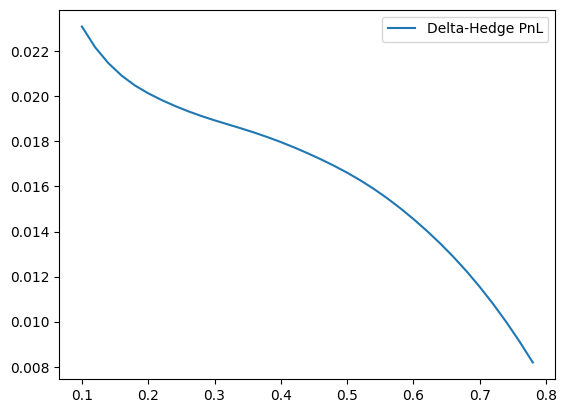

In [26]:
plt.plot(pnls[:, 0], pnls[:, 1])
plt.legend(["Delta-Hedge PnL"])
plt.show()

In [27]:
pnls[:, 1].mean() / pnls[:, 1].std(), pnls[:, 2].mean() / pnls[:, 2].std()

(4.456039006294055, 2.7242240675715874)

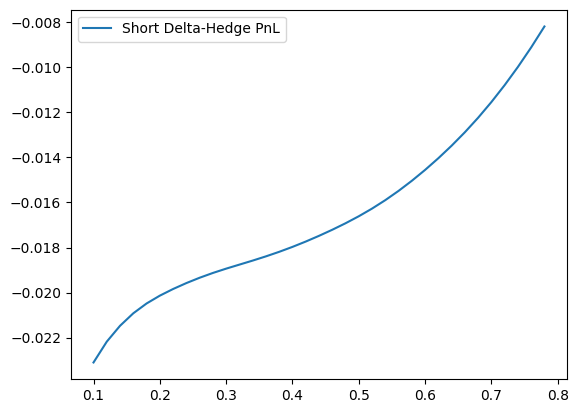

In [28]:
plt.plot(pnls[:, 0], -pnls[:, 1])
plt.legend(["Short Delta-Hedge PnL"])
plt.show()

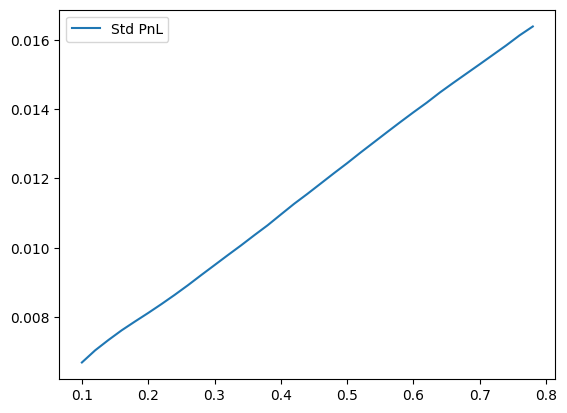

In [29]:
plt.plot(pnls[:, 0], pnls[:, 3])
plt.legend(["Std PnL"])
plt.show()